In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

In [2]:
data = pd.read_csv('quora_dataset.csv')
data.shape

(404290, 6)

In [3]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


### Class imbalance

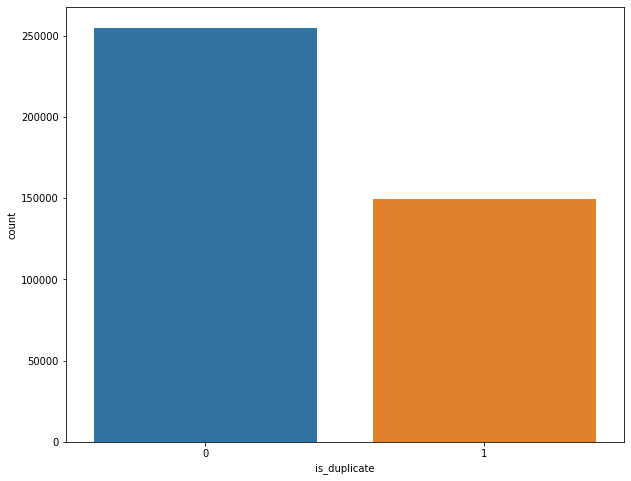

In [4]:
plt.figure(figsize=(10,8))
sns.countplot(x="is_duplicate", data=data)
plt.show()

In [5]:
data = data[data.question1.notnull() & data.question2.notnull()]
data.shape

(404287, 6)

### Converting question1 and question2 to lower-case

In [6]:
data['question1'] = data.question1.str.lower()
data['question2'] = data.question2.str.lower()

### Remove HTML tags

In [7]:
q1_tags = sum((data.question1.str.contains('<')) & (data.question1.str.contains('>')))
q2_tags = sum((data.question2.str.contains('<')) & (data.question2.str.contains('>')))

print('Before removing HTML tags: ')
print(f'Number of rows in question1 with both < & > operator: {q1_tags}')
print(f'Number of rows in question2 with both < & > operator: {q2_tags}')

Before removing HTML tags: 
Number of rows in question1 with both < & > operator: 53
Number of rows in question2 with both < & > operator: 32


In [8]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    updated_text = soup.get_text(separator=" ") 
    return updated_text

In [9]:
data['question1'] = data.question1.apply(remove_html_tags)
data['question2'] = data.question2.apply(remove_html_tags)

In [10]:
q1_tags = sum((data.question1.str.contains('<')) & (data.question1.str.contains('>')))
q2_tags = sum((data.question2.str.contains('<')) & (data.question2.str.contains('>')))

print('After removing HTML tags: ')
print(f'Number of rows in question1 with both < & > operator: {q1_tags}')
print(f'Number of rows in question2 with both < & > operator: {q2_tags}')

After removing HTML tags: 
Number of rows in question1 with both < & > operator: 28
Number of rows in question2 with both < & > operator: 9


data[data.question1.str.contains('^[<*>]', regex=True)]

### De-accent

In [11]:
data[(data.question1.str.contains('è')) | (data.question2.str.contains('è'))].head()

,id,qid1,qid2,question1,question2,is_duplicate
36858,36858,67161,67162,"what is the difference between “杂” (zá) and ”内脏"" (nèizàng)?","what is the difference between "";"" and "",""?",0
37327,37327,67940,67941,what does c-3p0 think happened to anakin skywalker?,why did anakin skywalker love padmè amidala?,0
40748,40748,73679,73680,what rain barrel would you suggest for pouring drinks in the top and opening to drain on the bottom?,"in eurofours pastry deck oven, what is the top and bottom temperature settings for meringue, macaron, crème brûlée, cakes and cookies, and choux pastry?",0
48448,48448,86378,86379,how do you pronounce the word ricqlès?,how do you pronounce the word anime?,0
54460,54460,96136,96137,"what is the difference between e, è, é, ê, ë, ē, ė, and ę?","why do i always get confused between the usage of english alphabets ""e"" and ""i""?",0


In [13]:
from gensim.utils import deaccent

data['question1'] = data.question1.apply(deaccent)
data['question2'] = data.question2.apply(deaccent)

In [14]:
data[(data.question1.str.contains('è')) | (data.question2.str.contains('è'))].head()

,id,qid1,qid2,question1,question2,is_duplicate


### Expand contractions
For example: "I don't wanna go out" tranformed to "I do not want to go out"

In [15]:
from pycontractions import Contractions
import gensim.downloader as api

model = api.load("glove-twitter-25")
cont = Contractions(kv_model=model) 
cont.load_models()

In [16]:
def expand_contractions(text):
    text = list(cont.expand_texts([text], precise=True))[0] 
    return text

In [17]:
data['question1'] = data.question1.apply(expand_contractions)
data['question2'] = data.question2.apply(expand_contractions)

data.to_csv('quora_preprocessed.csv', index=False)

data = pd.read_csv('quora_preprocessed.csv')

### Removing punctuations/special characters
Retaining alphanumeric characters only

In [56]:
data['question1'] = data.question1.str.replace('[^A-Za-z0-9 ]+','',regex=True)
data['question2'] = data.question2.str.replace('[^A-Za-z0-9 ]+','',regex=True)

### Stemming & lemmetization
Converting words to root form

In [57]:
def join_words(words):
    text = ' '.join(words)
    return text

In [58]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

print('Stemming question1')
data['question1'] = data['question1'].str.split()
data['question1'] = data['question1'].apply(lambda x: [stemmer.stem(y) for y in x])
data['question1'] = data['question1'].apply(join_words)

print('Stemming question2')
data['question2'] = data['question2'].str.split()
data['question2'] = data['question2'].apply(lambda x: [stemmer.stem(y) for y in x])
data['question2'] = data['question2'].apply(join_words)

Stemming question1
Stemming question2


In [59]:
data

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guid to invest in share market in india,what is the step by step guid to invest in share market,0
1,1,3,4,what is the stori of kohinoor kohinoor diamond,what would happen if the indian govern stole the kohinoor kohinoor diamond back,0
2,2,5,6,how can i increas the speed of my internet connect while use a vpn,how can internet speed be increas by hack through dns,0
3,3,7,8,whi am i mental veri lone how can i solv it,find the remaind when math2324math is divid by 2423,0
4,4,9,10,which one dissolv in water quik sugar salt methan and carbon di oxid,which fish would surviv in salt water,0
...,...,...,...,...,...,...
404282,404285,433578,379845,how mani keyword are there in the racket program languag of the latest version,how mani keyword are there in perl program languag in the latest version,0
404283,404286,18840,155606,do you believ there is life after death,is it true that there is life after death,1
404284,404287,537928,537929,what is one coin,what is this coin,0
404285,404288,537930,537931,what is the approx annual cost of live while studi in uic chicago for an indian student,i am have littl hairfal problem but i want to use hair style product which one should i prefer out of gel wax and clay,0


### Removing records with less than or equal to 10 characters in question1 or question2

In [60]:
data = data[(data.question1.str.len() > 10) & (data.question2.str.len() > 10)]

**Exporting to .csv**

In [61]:
data.to_csv('quora_preprocessed_v2.csv', index=False)